In [1]:
import os
#import sys

import wfdb

#import time

import numpy as np
#from numpy.linalg import norm
from numpy.linalg import inv
#import random as rnd
#import math as mth

import scipy.signal as scsig
#import scipy.linalg as sclin
import matplotlib.pyplot as plt
# import scipy.stats as scstat
# import scipy.ndimage as scndi

In [2]:
%run BaselineWonderRemoval.ipynb
%run RPeakDetector.ipynb
%run MiddleDetector.ipynb
%run RPeakReordering.ipynb
%run AddNoise.ipynb
%run ECGHeartBeatsList.ipynb
%run CheckThetaThetaTransposed.ipynb
%run ComputeMinAndMaxHeartbeatLength.ipynb
%run CheckSampleCovarianceMatrix.ipynb
%run MeanECGExtraction.ipynb

In [3]:
#srecord = wfdb.rdrecord('Data/s0010_re')
FILE_PATH = os.getcwd()
data_dir = FILE_PATH + '/../QTDataBase/'
data_files = os.listdir(data_dir) # get a listing of the directory
dat_files = [x.split('.')[0] for x in data_files]
#dat_files = sorted([f for f in data_files if f.endswith('.hea')]) # get a list of all the .atc files
#----- ---- --- -- -
file_name = 'sele0303'
#'sele0603' 'sele0612' 'sel41' 'sele0122' 'sel40' 'sele0612' 'sele0303'
#----- ---- --- -- -
file_to_read = data_dir + file_name
signals, fields = wfdb.rdsamp(file_to_read, sampfrom=0)
fs = fields["fs"]
ch_num = 0
s = signals[:,ch_num]
#----- ---- --- -- -
n_sec = 600
N = n_sec * fs 
ecg_clean = s[0: N]
tm = np.arange(0, N)/fs
#----- ---- --- -- -
bwr, ecg_bwr = BaselineWonderRemoval(signal = ecg_clean,
                                     win_l_MA = 0.5,
                                     win_l_MD = 0.71,
                                     fs = fs)
ecg_bp1, ecg_bp, ecg_tan, ecg_sq, ecg_MA_sq, peaks2, pks = RPeakDetector(signal = ecg_bwr, 
                                                                             frac = 0.5, 
                                                                             win_l_calib = 0.6, 
                                                                             win_l_peak_search = 0.5, 
                                                                             fs = fs)
mids = MiddleDetector(peaks2, len(ecg_bwr))
pks = RPeakReordering(pks, mids)
#----- ---- --- -- -
ecg = ecg_bwr[mids[0] : mids[-1]+1]                  # get the ecg, i.e. get the chunck between the first mid and last mid
ps = np.int_(pks - mids[0])                          # calibrate the peaks, by shifting with the mids[0] 
                                                     # which is the begining of the signal
    
ms = np.int_(mids - mids[0])                         # calibrate the midles, by shifting with the mids[0] 
                                                     # which is the begining of the signal

pshb = ps - ms[:-1]                                  # the peaks relative to each heartbeat, i.e. the position counting 
                                                     # from the heartbeat begining    
#----- ---- --- -- -
target_noise_db = 20                                 # set the target noise in dB
# Tau = 100                                          # set the number of bins (samples in phase space)
ecg_n, n, var_n = AddNoise(target_noise_db, ecg)     # get the noisy signal and the added noise signal
sd_n = np.sqrt(var_n)
#----- ---- --- -- -
x = ECGHeartBeatsList(ecg, ms)                       # x is the "pure" ecg, as list of heartbeats
x_f = np.concatenate(x, axis=0).tolist()             # x_f refers to x flatten, used in multiplications
Tau = ComputeMinAndMaxHeartbeatLength(x)[0]
# Tau = 100
#----- ---- --- -- -
x_n = ECGHeartBeatsList(ecg_n, ms)                   # x is the "noisy" ecg, as list of noisy heartbeats
x_n_f = np.concatenate(x_n, axis=0).tolist()         # x_n_f refers to x_n flatten, used in multiplications
#----- ---- --- -- -
print("selected file: ", file_name)
print("selected channel: ", ch_num)
print('number of seconds:', n_sec)
print('N = ', N)
print('# of samples in x: ', len(x_f))
print('# of hb in x: ', len(x))
print('smallest hb in x:', ComputeMinAndMaxHeartbeatLength(x)[0])
print('largest hb in x:', ComputeMinAndMaxHeartbeatLength(x)[1])
print('target noise dB:', target_noise_db)
print('noise variance:', var_n)
print('Tau:', Tau)
CheckThetaThetaTransposed(x, Tau)
CheckSampleCovarianceMatrix(x, Tau)
#----- ---- --- -- -

selected file:  sele0303
selected channel:  0
number of seconds: 600
N =  150000
# of samples in x:  149703
# of hb in x:  700
smallest hb in x: 198
largest hb in x: 224
target noise dB: 20
noise variance: 0.00037539878406904286
Tau: 198
[OK] Tau = 198 <= 198 = min(len(hb)) => Theta * Theta.T is diagonal hence invertible.
[OK] Tau = 198 <= 700 = n_hb => sampCov most probably invertible


In [4]:
#x in phase domain 
%run ComputeECGPhaseAndThetaList.ipynb
%run ComputeTheta.ipynb
#----- ---- --- -- -
xph, Th = ComputeECGPhaseAndThetaList(x_n, pshb, Tau)  # xph is list of transformed heartbeats for x, Theta is the transf
Theta = ComputeTheta(Th)                             # Theta is formed from each Th_i, by concatenation and normalization

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


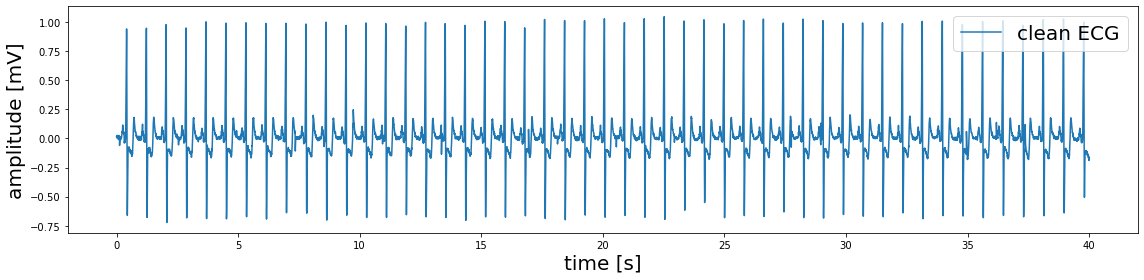

In [5]:
fig = plt.figure(figsize = (16, 4))
detail = 10000
fntsiz = 20
target_file = '../IEEEFigs/ECG'
plt.plot(np.arange(len(x_f[0:detail]))/fs, x_f[0:detail], label  = "clean ECG")
plt.legend(fontsize = fntsiz, loc = 1)
plt.xlabel("time [s]", fontsize = fntsiz)
plt.ylabel("amplitude [mV]", fontsize = fntsiz)
#--------
fig.tight_layout()
plt.savefig(target_file + file_name + '.eps', format = 'eps', bbox_inches='tight')
plt.savefig(target_file + file_name + '.png', format = 'png', bbox_inches='tight')
#--------
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


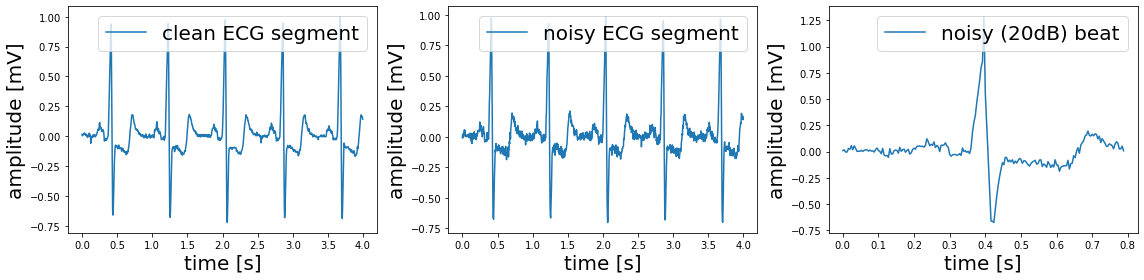

In [6]:
fig = plt.figure(figsize = (16, 4))
detail = 1000
fntsiz = 20
target_file = '../IEEEFigs/ECGSeg'
#--------
plt.subplot(1,3,1)
plt.plot(np.arange(len(x_f[0:detail]))/fs, x_f[0:detail], label  = "clean ECG segment")
plt.legend(fontsize = fntsiz, loc = 1)
plt.xlabel("time [s]", fontsize = fntsiz)
plt.ylabel("amplitude [mV]", fontsize = fntsiz)
#--------
plt.subplot(1,3,2)
plt.plot(np.arange(len(x_f[0:detail]))/fs, x_n_f[0:detail], label  = "noisy ECG segment")
plt.legend(fontsize = fntsiz, loc = 1)
plt.xlabel("time [s]", fontsize = fntsiz)
plt.ylabel("amplitude [mV]", fontsize = fntsiz)
#--------
plt.subplot(1,3,3)
plt.plot(np.arange(len(xph[0]))/fs, xph[0], label  = "noisy (" + str(target_noise_db) + "dB) beat")
plt.legend(fontsize = fntsiz, loc = 1)
plt.xlabel("time [s]", fontsize = fntsiz)
plt.ylabel("amplitude [mV]", fontsize = fntsiz)
#--------
fig.tight_layout()
plt.savefig(target_file + file_name + '_' + str(target_noise_db) + 'dB.eps', format = 'eps', bbox_inches='tight')
plt.savefig(target_file + file_name + '_'+ str(target_noise_db) + 'dB.png', format = 'png', bbox_inches='tight')
#--------
plt.show()

In [7]:
B = np.matmul(Th[0],Th[0].T)
invB = np.linalg.inv(B)

In [8]:
xph_f = np.concatenate(xph, axis=0).tolist()         # xph_f refers to xph flatten, used in multiplications
mu_xph = np.mean(xph, axis=0)
#mu_xph = np.asarray(Theta * np.asmatrix(x_f).T)      # mu_xph is the mean-binned signal x in the phase domain

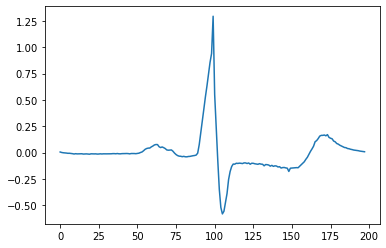

In [9]:
plt.plot(mu_xph)

In [10]:
%run ComputeSampleCovariances.ipynb
S_xph, S_sph, var_xph, var_sph = ComputeSampleCovariances(xph, var_n, B)
sd_xph = np.sqrt(var_xph)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


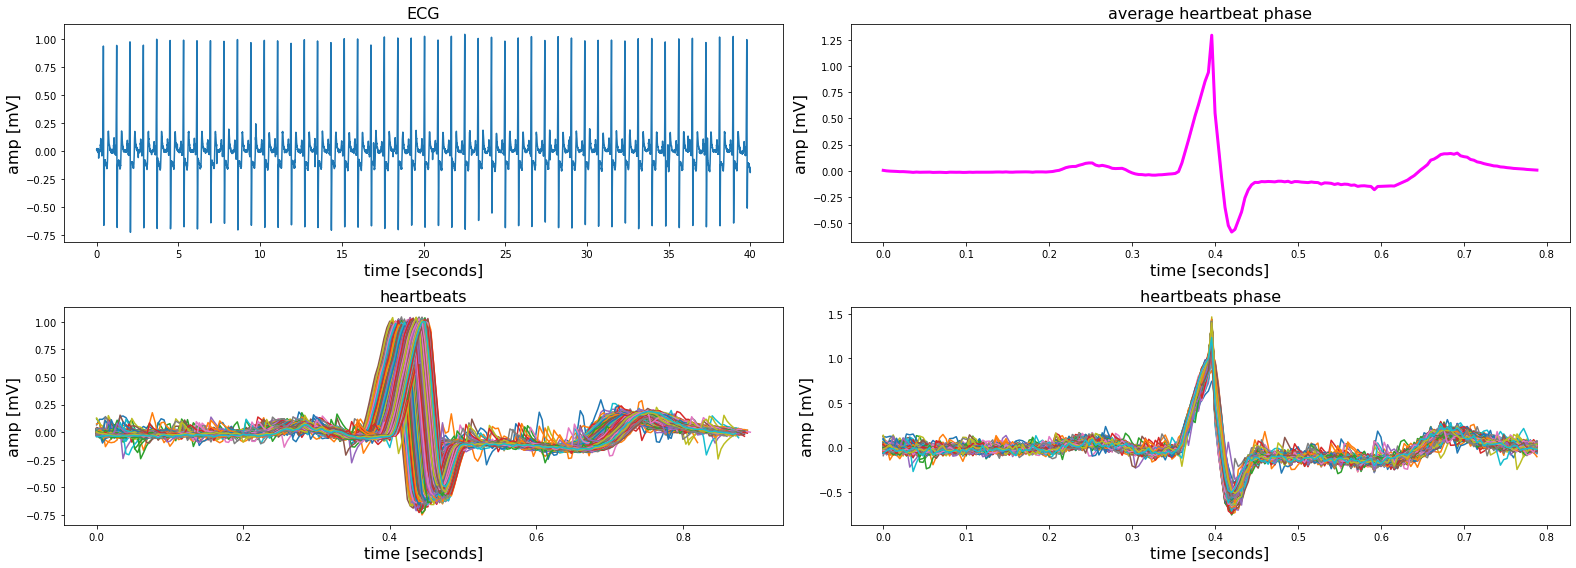

In [11]:
%run PlotTransitionECG.ipynb
target_file = '../Figs/pISCE_GP_TransFS2'
detail = 10000
PlotTransitionECG(x, xph, mu_xph, var_xph, fs, target_file, detail)

In [12]:
%run ComputeSampleCovariances.ipynb
Sxph, Ssph, varxph, varsph = ComputeSampleCovariances(xph, var_n, B)
invSxph = np.linalg.inv(Sxph) 
SxphinvSxph = np.matmul(Sxph,invSxph)

# Filter

In [13]:
%run ComputeECGmean.ipynb
mu_s = ComputeECGmean(Theta, invB, mu_xph)
diff = np.array(x_n_f) - np.array(mu_s)
Rho = 1/var_n * np.linalg.inv(Ssph) 
M = invB - np.linalg.inv(len(x) * Rho + B)
s_h = np.array(mu_s) + 1/len(x) * np.matmul(Theta.T, np.matmul(M, np.matmul(Theta, diff)))
s_h1 = 1/len(x) * np.matmul(Theta.T, np.matmul(M, np.matmul(Theta, np.array(x_n_f))))
#s_hCC = np.array(mu_s) + 1/len(x) * np.matmul(Theta.T, np.matmul(D, np.matmul(Theta, diff)))

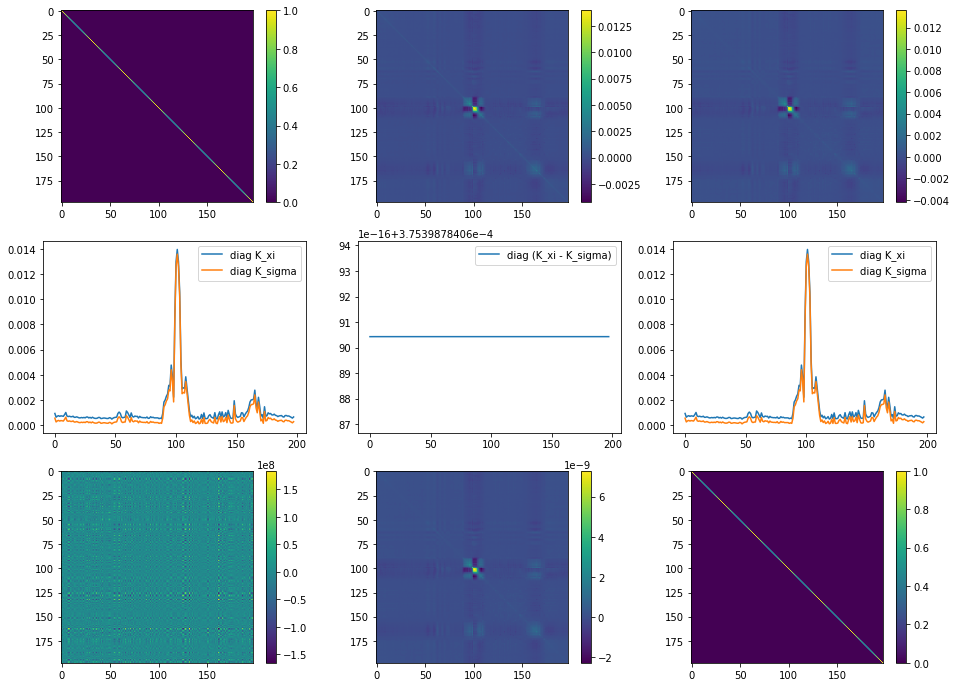

In [14]:
fig = plt.figure(figsize = (16, 12))
#--------
plt.subplot(3,3,1)
plt.imshow(B)
plt.colorbar()
#--------
plt.subplot(3,3,2)
plt.imshow(Sxph)
plt.colorbar()
#--------
plt.subplot(3,3,3)
plt.imshow(Ssph)
plt.colorbar()
#--------
plt.subplot(3,3,4)
plt.plot(np.diag(Sxph), label = 'diag K_xi')
plt.plot(np.diag(Ssph), label = 'diag K_sigma')
plt.legend()
#--------
plt.subplot(3,3,5)
plt.plot(np.diag(Sxph) - np.diag(Ssph), label = 'diag (K_xi - K_sigma)')
plt.legend()
#--------
plt.subplot(3,3,6)
plt.plot(np.diag(Sxph), label = 'diag K_xi')
plt.plot(np.diag(Ssph), label = 'diag K_sigma')
plt.legend()
#--------
plt.subplot(3,3,7)
plt.imshow(Rho)
plt.colorbar()
#--------
plt.subplot(3,3,8)
plt.imshow(np.linalg.inv(len(x) * Rho + B))
plt.colorbar()
#--------
plt.subplot(3,3,9)
plt.imshow(M)
plt.colorbar()

In [15]:
%run ComputeInputOutputDeltaSNRs.ipynb
print(ComputeInputOutputDeltaSNRs(x_f, n, s_h1))
print(ComputeInputOutputDeltaSNRs(x_f, n, s_h))
print(ComputeInputOutputDeltaSNRs(x_f, n, mu_s))

(20.007849522941378, 16.35407094393773, -3.653778579003646)
(20.007849522941378, 16.354079440905227, -3.65377008203615)
(20.007849522941378, 16.354070944725123, -3.6537785782162544)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


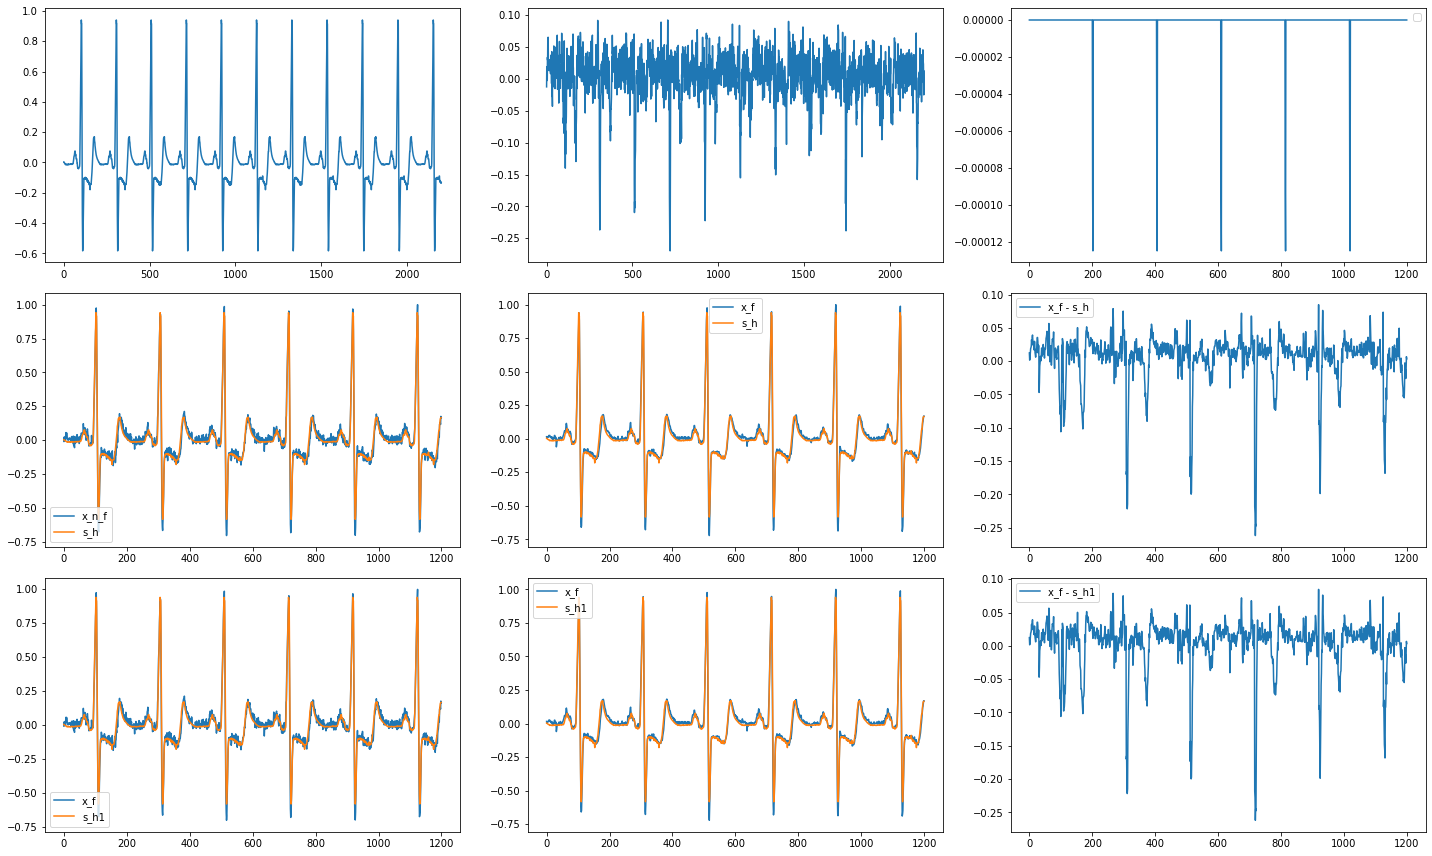

In [16]:
ttt = 1/len(x) * np.matmul(Theta.T, np.matmul(M, np.matmul(Theta, diff)))
fig = plt.figure(figsize = (20,12))    
#-----------------------
plt.subplot(3,3,1)
plt.plot(mu_s[0:2200])
#-----
plt.subplot(3,3,2)
plt.plot(diff[0:2200])
#-----
plt.subplot(3,3,3)
plt.plot(ttt[0:1200])
plt.legend()
#-----------------------
plt.subplot(3,3,4)
plt.plot(x_n_f[0:1200], label  = 'x_n_f')
plt.plot(s_h[0:1200], label  = 's_h')
plt.legend()
#-----
plt.subplot(3,3,5)
plt.plot(x_f[0:1200], label  = 'x_f')
plt.plot(s_h[0:1200], label  = 's_h')
plt.legend()
#-----
diff = x_f - s_h
plt.subplot(3,3,6)
plt.plot(diff[0:1200], label  = 'x_f - s_h')
plt.legend()
#-----------------------
plt.subplot(3,3,7)
plt.plot(x_n_f[0:1200], label  = 'x_f')
plt.plot(s_h1[0:1200], label  = 's_h1')
plt.legend()
#-----
plt.subplot(3,3,8)
plt.plot(x_f[0:1200], label  = 'x_f')
plt.plot(s_h1[0:1200], label  = 's_h1')
plt.legend()
#-----
diff = x_f - s_h1
plt.subplot(3,3,9)
plt.plot(diff[0:1200], label  = 'x_f - s_h1')
plt.legend()
#-----------------------
fig.tight_layout()

# Filter F (i.e. with the filtered Theta)

In [17]:
# Theta is filtered for a smoother filter
%run MovingAverageMatrixFilter.ipynb
ThetaF = MovingAverageMatrixFilter(Theta, 5)

In [74]:
%run ComputeECGmean.ipynb
mu_s = ComputeECGmean(ThetaF, invB, mu_xph)
diff = np.array(x_n_f) - np.array(mu_s)
Rho = 1/var_n * np.linalg.inv(Ssph) 
M = invB - np.linalg.inv(len(x) * Rho + B)
#D = 
s_h = np.array(mu_s) + 1/len(x) * np.matmul(ThetaF.T, np.matmul(M, np.matmul(ThetaF, diff)))
s_h1 = 1/len(x) * np.matmul(Theta.T, np.matmul(M, np.matmul(ThetaF, np.array(x_n_f))))
#s_hCC = np.array(mu_s) + 1/len(x) * np.matmul(Theta.T, np.matmul(D, np.matmul(Theta, diff)))

In [75]:
print(ComputeInputOutputDeltaSNRs(x_f, n, s_h1))
print(ComputeInputOutputDeltaSNRs(x_f, n, s_h))
print(ComputeInputOutputDeltaSNRs(x_f, n, mu_s))

(20.007849522941378, 14.696187638086048, -5.311661884855329)
(20.007849522941378, 16.483741848897324, -3.5241076740440533)
(20.007849522941378, 15.102438273209371, -4.905411249732007)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


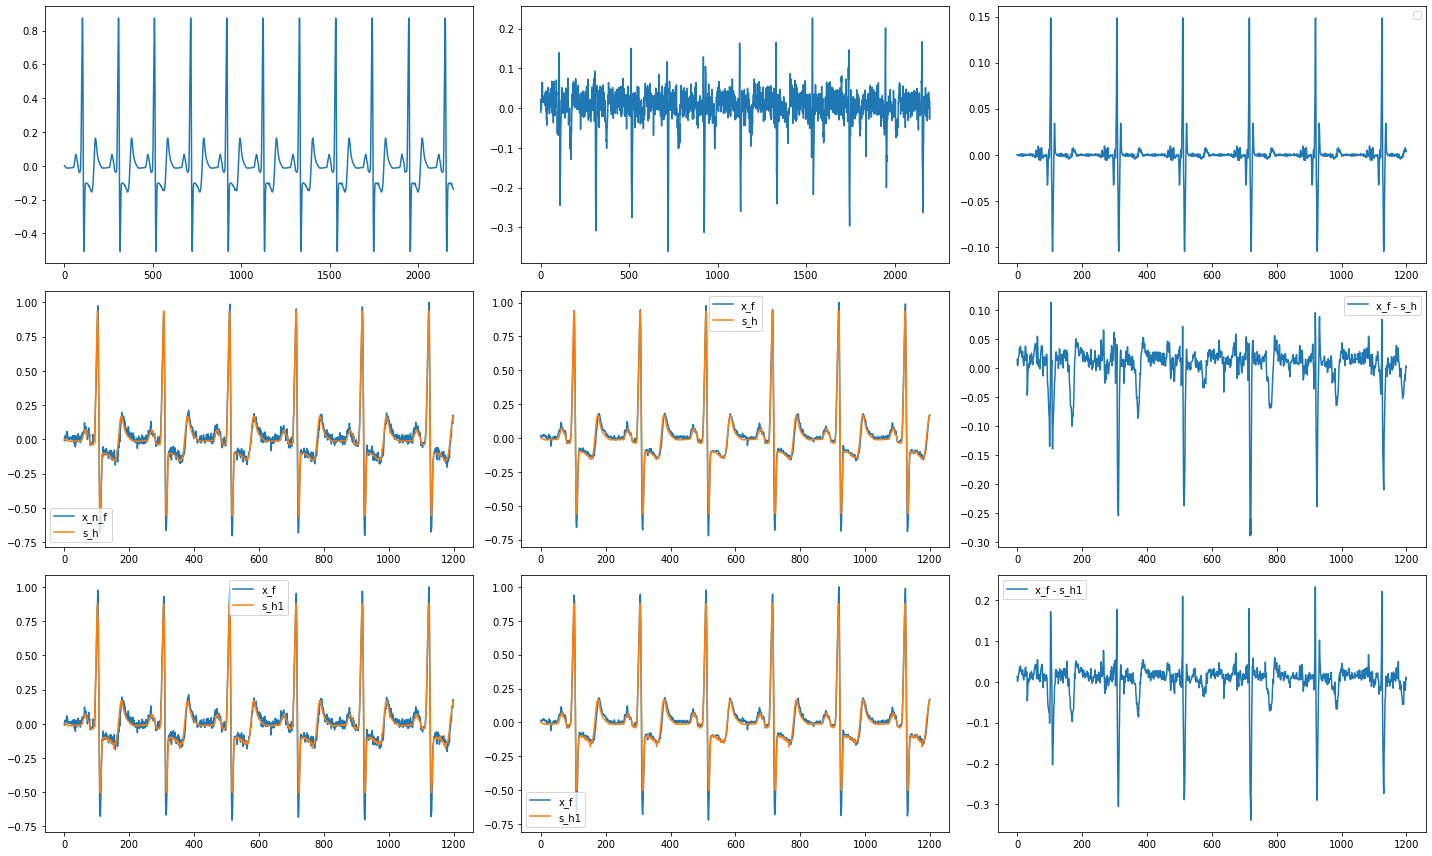

In [76]:
ttt = 1/len(x) * np.matmul(Theta.T, np.matmul(M, np.matmul(Theta, diff)))
fig = plt.figure(figsize = (20,12))    
#-----------------------
plt.subplot(3,3,1)
plt.plot(mu_s[0:2200])
#-----
plt.subplot(3,3,2)
plt.plot(diff[0:2200])
#-----
plt.subplot(3,3,3)
plt.plot(ttt[0:1200])
plt.legend()
#-----------------------
plt.subplot(3,3,4)
plt.plot(x_n_f[0:1200], label  = 'x_n_f')
plt.plot(s_h[0:1200], label  = 's_h')
plt.legend()
#-----
plt.subplot(3,3,5)
plt.plot(x_f[0:1200], label  = 'x_f')
plt.plot(s_h[0:1200], label  = 's_h')
plt.legend()
#-----
diff = x_f - s_h
plt.subplot(3,3,6)
plt.plot(diff[0:1200], label  = 'x_f - s_h')
plt.legend()
#-----------------------
plt.subplot(3,3,7)
plt.plot(x_n_f[0:1200], label  = 'x_f')
plt.plot(s_h1[0:1200], label  = 's_h1')
plt.legend()
#-----
plt.subplot(3,3,8)
plt.plot(x_f[0:1200], label  = 'x_f')
plt.plot(s_h1[0:1200], label  = 's_h1')
plt.legend()
#-----
diff = x_f - s_h1
plt.subplot(3,3,9)
plt.plot(diff[0:1200], label  = 'x_f - s_h1')
plt.legend()
#-----------------------
fig.tight_layout()

In [77]:
TheTheT = np.matmul(Theta,Theta.T)
TheFTheFT = np.matmul(ThetaF,ThetaF.T)

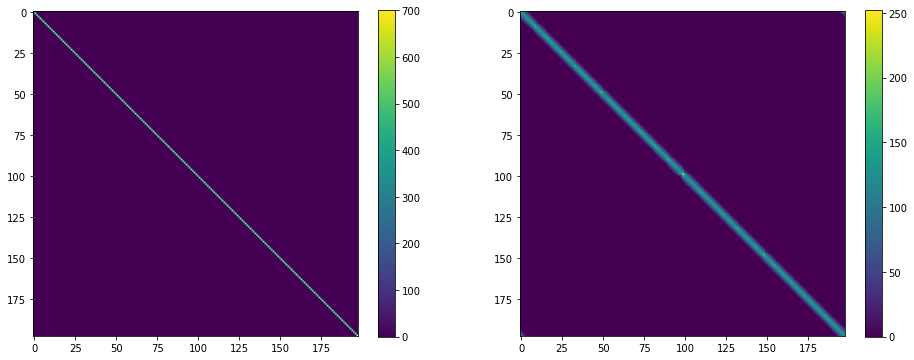

In [78]:
fig = plt.figure(figsize = (16,6))    
#--------
plt.subplot(1,2,1)
plt.imshow(TheTheT)
plt.colorbar()
#--------
plt.subplot(1,2,2)
plt.imshow(TheFTheFT)
plt.colorbar()
#--------

In [79]:
#import random
#rn = random.choices(range(1, 100), k=Theta.shape[1])
naive1 = 1/len(x) * np.matmul(Theta.T,np.matmul(Theta,x_n_f))
naive2 = 1/len(x) * np.matmul(ThetaF.T,np.matmul(ThetaF,x_n_f))

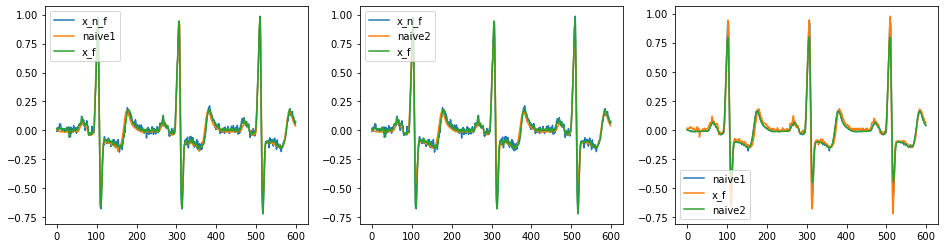

In [80]:
fig = plt.figure(figsize = (16,4))    
#------------
plt.subplot(1,3,1)
plt.plot(x_n_f[0:600], label  = 'x_n_f')
plt.plot(naive1[0:600], label  = 'naive1')
plt.plot(x_f[0:600], label  = 'x_f')
plt.legend()
#------------
plt.subplot(1,3,2)
plt.plot(x_n_f[0:600], label  = 'x_n_f')
plt.plot(naive2[0:600], label  = 'naive2')
plt.plot(x_f[0:600], label  = 'x_f')
plt.legend()
#------------
plt.subplot(1,3,3)
plt.plot(naive1[0:600], label  = 'naive1')
plt.plot(x_f[0:600], label  = 'x_f')
plt.plot(naive2[0:600], label  = 'naive2')
plt.legend()
#------------

In [81]:
Theta.shape[1]

149703

In [82]:
#TheTThe = np.matmul(Theta.T,Theta)

In [83]:
ThThT = np.matmul(Th[0],Th[0].T)
ThTTh = np.matmul(Th[0].T,Th[0])

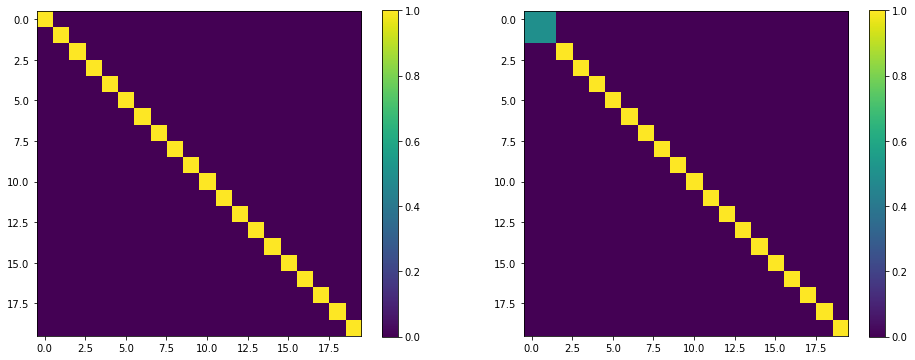

In [84]:
fig = plt.figure(figsize = (16,6))    
plt.subplot(1,2,1)
plt.imshow(ThThT[0:20,0:20,])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(ThTTh[0:20,0:20,])
plt.colorbar()

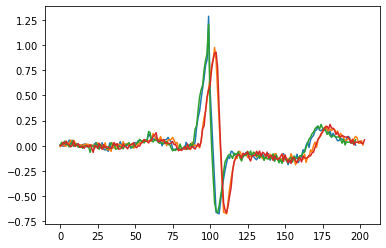

In [85]:
plt.plot(np.matmul(Th[0], x_n[0]))
plt.plot(x_n[0])
plt.plot(np.matmul(Th[1], x_n[1]))
plt.plot(x_n[1])

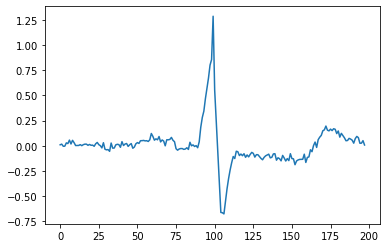

In [86]:
plt.plot(np.matmul(Th[0], x_n[0]))

In [87]:
%run ComputeECGmean2.ipynb
%run GPFilter.ipynb
mu_s = ComputeECGmean2(Th, invB, mu_xph)
Rho = 1/var_n * np.linalg.inv(Ssph) 
M = invB - np.linalg.inv(len(x) * Rho + B)
s_h = GPFilter(mu_s, Th, M, invB, x_n)
#----
mu_s_f = np.concatenate(mu_s, axis=0).tolist()      
s_h_f = np.concatenate(s_h, axis=0).tolist()      

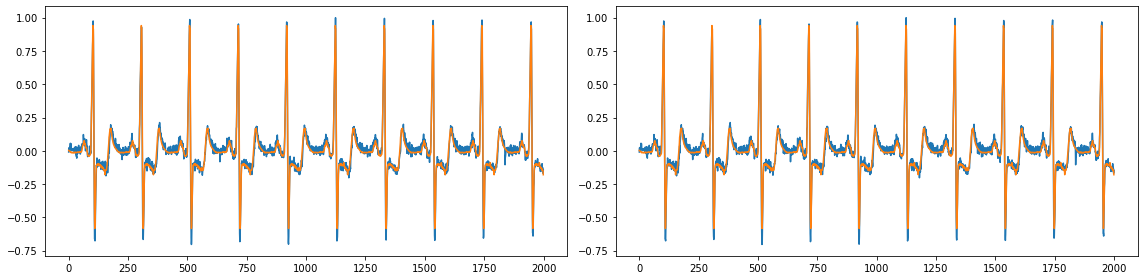

In [89]:
fig = plt.figure(figsize = (16,4))    
plt.subplot(1,2,1)
plt.plot(x_n_f[0:2000])
plt.plot(mu_s_f[0:2000])
plt.subplot(1,2,2)
plt.plot(x_n_f[0:2000])
plt.plot(s_h_f[0:2000])
fig.tight_layout()

In [90]:
print(ComputeInputOutputDeltaSNRs(x_f, n, s_h_f))
print(ComputeInputOutputDeltaSNRs(x_f, n, mu_s_f))

(20.007849522941378, 16.365405873004434, -3.6424436499369435)
(20.007849522941378, 16.354070944725123, -3.6537785782162544)


In [55]:
filt = []
for i in np.arange(len(x_n)):    
    filt.append(mu_s[i] + np.matmul(Th[i].T, np.matmul(M, np.matmul(Th[i], x_n[i] - mu_s[i]))))
filt_f = np.concatenate(filt, axis=0).tolist()      

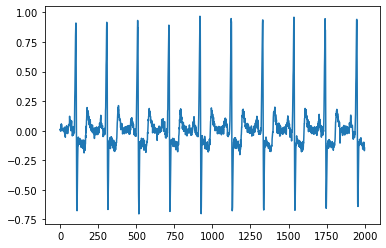

In [56]:
plt.plot(filt_f[0:2000])